##  Experimentation with Vision Transformer Model
    We're going to be replicating the machine learning research paper [*An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale*](https://arxiv.org/abs/2010.11929)  (ViT paper) with PyTorch.

The Transformer neural network architecture was originally introduced in the machine learning research paper [*Attention is all you need*](https://arxiv.org/abs/1706.03762).

And the original Transformer architecture was designed to work on one-dimensional (1D) sequences of text.

A **Transformer architecture** is generally considered to be any neural network that uses the [**attention mechanism**](https://en.wikipedia.org/wiki/Attention_(machine_learning)) as its primary learning layer. Similar to how a convolutional neural network (CNN) uses convolutions as its primary learning layer.



The original Vision Transformer has been through several iterations over the past couple of years, however, we're going to focus on replicating the original, otherwise known as the "vanilla Vision Transformer". Because if you can recreate the original, you can adapt to the others.

We're going to be focusing on building the ViT architecture as per the original ViT paper and applying it to Lettuce Leaf Classification.

| **Topic** | **Contents** |
| ----- | ----- |
| **[0. Getting setup](https://www.learnpytorch.io/08_pytorch_paper_replicating/#0-getting-setup)** | We've written a fair bit of useful code over the past few sections, let's download it and make sure we can use it again. |
| **[1. Get data](https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data)** | Let's get the pizza, steak and sushi image classification dataset we've been using and build a Vision Transformer to try and improve FoodVision Mini model's results. |
| **[2. Create Datasets and DataLoaders](https://www.learnpytorch.io/08_pytorch_paper_replicating/#2-create-datasets-and-dataloaders)** | We'll use the `data_setup.py` script we wrote in chapter 05. PyTorch Going Modular to setup our DataLoaders. |
| **[3. Replicating the ViT paper: an overview](https://www.learnpytorch.io/08_pytorch_paper_replicating/#3-replicating-the-vit-paper-an-overview)** | Replicating a machine learning research paper can be bit a fair challenge, so before we jump in, let's break the ViT paper down into smaller chunks, so we can replicate the paper chunk by chunk. |
| **[4. Equation 1: The Patch Embedding](https://www.learnpytorch.io/08_pytorch_paper_replicating/#4-equation-1-split-data-into-patches-and-creating-the-class-position-and-patch-embedding)** | The ViT architecture is comprised of four main equations, the first being the patch and position embedding. Or turning an image into a sequence of learnable patches. |
| **[5. Equation 2: Multi-Head Attention (MSA)](https://www.learnpytorch.io/08_pytorch_paper_replicating/#5-equation-2-multi-head-attention-msa)** | The self-attention/multi-head self-attention (MSA) mechanism is at the heart of every Transformer architecture, including the ViT architecture, let's create an MSA block using PyTorch's in-built layers. |
| **[6. Equation 3: Multilayer Perceptron (MLP)](https://www.learnpytorch.io/08_pytorch_paper_replicating/#6-equation-3-multilayer-perceptron-mlp)** | The ViT architecture uses a multilayer perceptron as part of its Transformer Encoder and for its output layer. Let's start by creating an MLP for the Transformer Encoder. |
| **[7. Creating the Transformer Encoder](https://www.learnpytorch.io/08_pytorch_paper_replicating/#7-create-the-transformer-encoder)** | A Transformer Encoder is typically comprised of alternating layers of MSA (equation 2) and MLP (equation 3) joined together via residual connections. Let's create one by stacking the layers we created in sections 5 & 6 on top of each other.  |
| **[8. Putting it all together to create ViT](https://www.learnpytorch.io/08_pytorch_paper_replicating/#8-putting-it-all-together-to-create-vit)** | We've got all the pieces of the puzzle to create the ViT architecture, let's put them all together into a single class we can call as our model. |
| **[9. Setting up training code for our ViT model](https://www.learnpytorch.io/08_pytorch_paper_replicating/#9-setting-up-training-code-for-our-vit-model)** | Training our custom ViT implementation is similar to all of the other models we've trained previously. And thanks to our `train()` function in `engine.py` we can start training with a few lines of code. |
| **[10. Using a pretrained ViT from `torchvision.models`](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset)** | Training a large model like ViT usually takes a fair amount of data. Since we're only working with a small amount of pizza, steak and sushi images, let's see if we can leverage the power of transfer learning to improve our performance. |
| **[11. Make predictions on a custom image](https://www.learnpytorch.io/08_pytorch_paper_replicating/#11-make-predictions-on-a-custom-image)** | The magic of machine learning is seeing it work on your own data, so let's take our best performing model and put FoodVision Mini to the test on the infamous *pizza-dad* image (a photo of my dad eating pizza). |


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [2]:
from modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

f:\Lettuce_leaf_classification\Lettuce_leaf_classification\leaf_classf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 2. Create Datasets and DataLoaders

Now we've got some data, let's now turn it into `DataLoader`'s.

To do so we can use the `create_dataloaders()` function in [`data_setup.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/data_setup.py).

First, we'll create a transform to prepare our images.

This where one of the first references to the ViT paper will come in.

In Table 3, the training resolution is mentioned as being 224 (height=224, width=224).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-image-size-and-batch-size.png" width=900 alt="Table 3 from the Vision Transformer paper showing the image size and batch size"/>

*You can often find various hyperparameter settings listed in a table. In this case we're still preparing our data, so we're mainly concerned with things like image size and batch size. Source: Table 3 in [ViT paper](https://arxiv.org/abs/2010.11929).*

So we'll make sure our transform resizes our images appropriately.

And since we'll be training our model from scratch (no transfer learning to begin with), we won't provide a `normalize` transform like we did in [06. PyTorch Transfer Learning section 2.1](https://www.learnpytorch.io/06_pytorch_transfer_learning/#21-creating-a-transform-for-torchvisionmodels-manual-creation).

### 2.1 Prepare transforms for images

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ]
)
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
from pathlib import Path

In [ ]:
from pathlib import Path

image_path = "F:\Lettuce_leaf_classification\DNN_dataloader"
image_path = Path(image_path)
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('F:/Lettuce_leaf_classification/DNN_dataloader/train'),
 WindowsPath('F:/Lettuce_leaf_classification/DNN_dataloader/test'))

In [ ]:
# Set the batch size
BATCH_SIZE = (
    32  # this is lower than the ViT paper but it's because we're starting small
)

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  # use manually created transforms
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x14abd579b40>,
 ['BACT', 'DML', 'HLTY', 'PML', 'SBL', 'SPW', 'VIRL', 'WLBL'])

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

f:\Lettuce_leaf_classification\Lettuce_leaf_classification\leaf_classf\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(7))

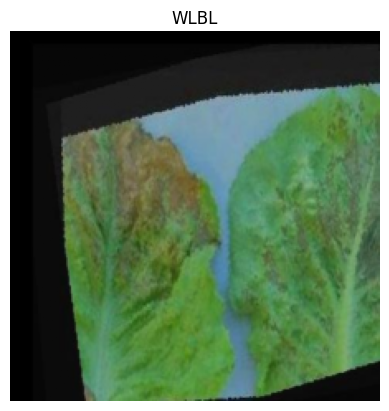

In [ ]:
# Plot image with matplotlib
plt.imshow(
    image.permute(1, 2, 0)
)  # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating the ViT paper: an overview

Before we write any more code, let's discuss what we're doing.

We'd like to replicate the ViT paper for our own problem, Lettuce Leaf.

So our **model inputs** are: images of 8 distinct classes of images.

And our ideal **model outputs** are: predicted labels of HLTY,VIRl,WLBL,SPW,SBL ,etc .....


#### 3.1 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more computation.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more computation. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

I remember one of my machine learning engineer friends used to say "it's all about the embedding."

As in, if you can represent your data in a good, learnable way (as **embeddings are learnable representations**), chances are, a learning algorithm will be able to perform well on them.

With that being said, let's start by creating the class, position and patch embeddings for the ViT architecture.

We'll start with the **patch embedding**.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

Recall that an **embedding** is a learnable representation of some form and is often a vector.

The term learnable is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

And size we're dealing with image shapes, let's keep in mind the line from Table 3 of the ViT paper:

> Training resolution is **224**.

Let's break down the text above.

* $D$ is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png" width=900 alt="mapping the vit architecture diagram positional and patch embeddings portion to the relative mathematical equation describing what's going on"/>

*Mapping the patch and position embedding portion of the ViT architecture from Figure 1 to Equation 1. The opening paragraph of section 3.1 describes the different input and output shapes of the patch embedding layer.*

### 4.1 Calculating patch embedding input and output shapes by hand

How about we start by calculating these input and output shape values by hand?

To do so, let's create some variables to mimic each of the terms (such as $H$, $W$ etc) above.

We'll use a patch size ($P$) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).

In [ ]:
# Create example values
height = 224  # H ("The training resolution is 224.")
width = 224  # W
color_channels = 3  # C
patch_size = 16  # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(
    f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}"
)

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


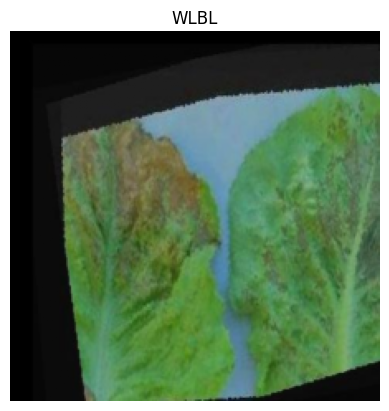

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0))  # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)

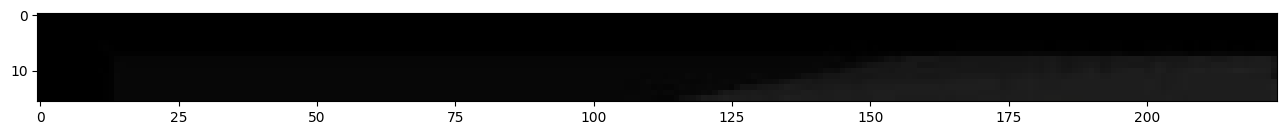

In [ ]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


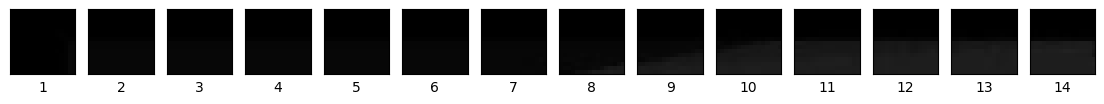

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(
    f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels"
)

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=1,
    ncols=img_size // patch_size,  # one column for each patch
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True,
)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch : patch + patch_size, :])
    # keep height index constant, alter the width index
    axs[i].set_xlabel(i + 1)  # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


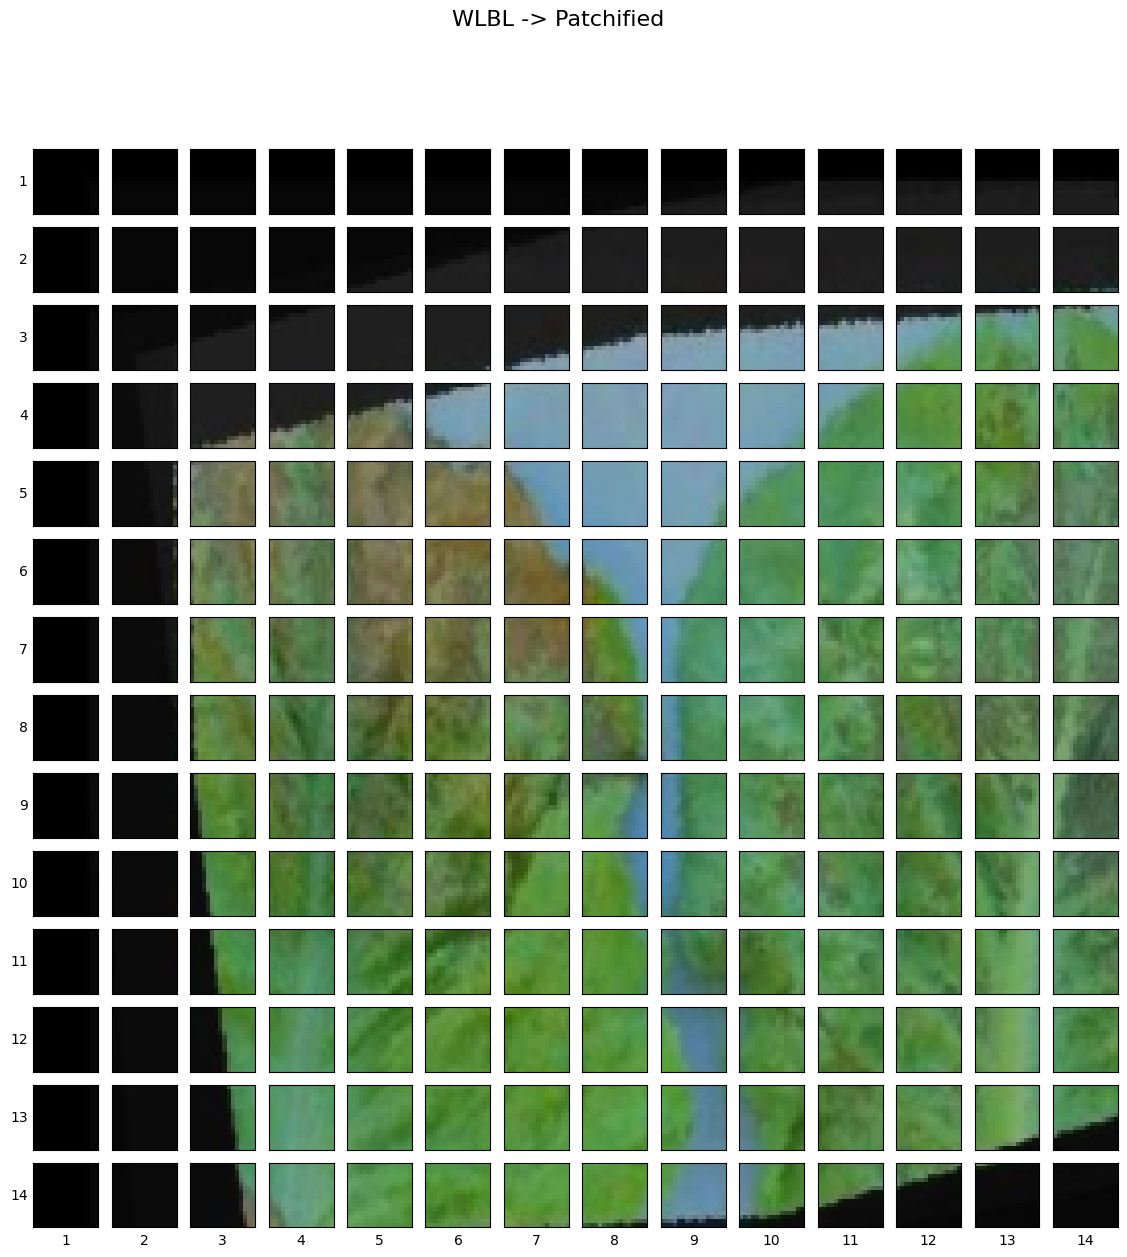

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(
    f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels"
)

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=img_size // patch_size,  # need int not float
    ncols=img_size // patch_size,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True,
)

# Loop through height and width of image
for i, patch_height in enumerate(
    range(0, img_size, patch_size)
):  # iterate through height
    for j, patch_width in enumerate(
        range(0, img_size, patch_size)
    ):  # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(
            image_permuted[
                patch_height : patch_height + patch_size,  # iterate through height
                patch_width : patch_width + patch_size,  # iterate through width
                :,
            ]
        )  # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(
            i + 1,
            rotation="horizontal",
            horizontalalignment="right",
            verticalalignment="center",
        )
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches with `torch.nn.Conv2d()`

We've seen what an image looks like when it gets turned into patches, now let's start moving towards replicating the patch embedding layers with PyTorch.

To visualize our single image we wrote code to loop through the different height and width dimensions of a single image and plot individual patches.

This operation is very similar to the convolutional operation we saw in [03. PyTorch Computer Vision section 7.1: Stepping through `nn.Conv2d()`](https://www.learnpytorch.io/03_pytorch_computer_vision/#71-stepping-through-nnconv2d).

In fact, the authors of the ViT paper mention in section 3.1 that the patch embedding is achievable with a convolutional neural network (CNN):  

> **Hybrid Architecture.** As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a **CNN feature map**. As a special case, the patches can have spatial size $1 \times 1$, which means that the **input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension**. The classification input embedding and position embeddings are added as described above.

The "**feature map**" they're referring to are the weights/activations produced by a convolutional layer passing over a given image.

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-patch-embedding-animation.gif" width=900 alt="example of creating a patch embedding by passing a convolutional layer over a single image"/>

*By setting the `kernel_size` and `stride` parameters of a [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer equal to the `patch_size`, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.*

Remember our ideal input and output shapes for the patch embedding layer?

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Or for an image size of 224 and patch size of 16:

* **Input (2D image):** (224, 224, 3) -> (height, width, color channels)
* **Output (flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:
* [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for turning our image into patches of CNN feature maps.
* [`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) for flattening the spatial dimensions of the feature map.

Let's start with the `torch.nn.Conv2d()` layer.

We can replicate the creation of patches by setting the `kernel_size` and `stride` equal to `patch_size`.

This means each convolutional kernel will be of size `(patch_size x patch_size)` or if `patch_size=16`, `(16 x 16)` (the equivalent of one whole patch).

And each step or `stride` of the convolutional kernel will be `patch_size` pixels long or `16` pixels long (equivalent of stepping to the next patch).

We'll set `in_channels=3` for the number of color channels in our image and we'll set `out_channels=768`, the same as the $D$ value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size 768).

In [ ]:
# Set the patch size
patch_size = 16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(
    in_channels=3,  # number of color channels
    out_channels=768,  # from Table 1: Hidden size D, this is the embedding size
    kernel_size=patch_size,  # could also use (patch_size, patch_size)
    stride=patch_size,
    padding=0,
)

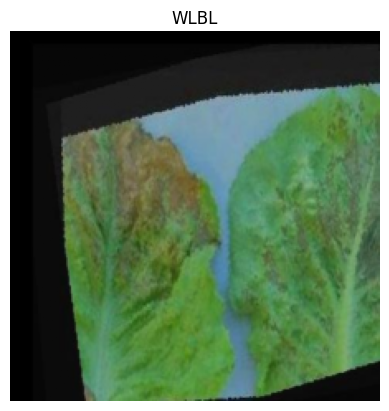

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0))  # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(
    image.unsqueeze(0)
)  # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [484, 708, 615, 65, 720]


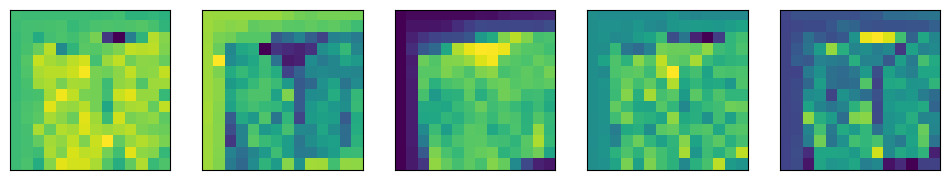

In [ ]:
# Plot random 5 convolutional feature maps
import random

random_indexes = random.sample(
    range(0, 758), k=5
)  # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[
        :, idx, :, :
    ]  # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [25]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0288, -0.0354, -0.0354, -0.0354, -0.0354, -0.0354, -0.0351,
           -0.0521, -0.0385, -0.0538, -0.0591, -0.0618, -0.0645, -0.0660],
          [-0.0276, -0.0374, -0.0414, -0.0408, -0.0535, -0.0645, -0.0711,
           -0.0801, -0.0790, -0.0821, -0.0787, -0.0789, -0.0846, -0.1027],
          [-0.0297, -0.0608, -0.0782, -0.0830, -0.0819, -0.0881, -0.1859,
           -0.2270, -0.3105, -0.2019, -0.1593, -0.1218, -0.1633, -0.2631],
          [-0.0293, -0.0620, -0.1823, -0.1088, -0.1287, -0.3266, -0.3006,
           -0.2997, -0.2838, -0.2680, -0.2631, -0.2368, -0.2323, -0.2354],
          [-0.0293, -0.0974, -0.1978, -0.2315, -0.2568, -0.2047, -0.2745,
           -0.2795, -0.2893, -0.2167, -0.2351, -0.2232, -0.2111, -0.2135],
          [-0.0293, -0.0734, -0.2047, -0.2290, -0.2409, -0.1887, -0.2241,
           -0.2771, -0.2257, -0.2552, -0.2405, -0.2089, -0.2108, -0.2288],
          [-0.0293, -0.0518, -0.2146, -0.1642, -0.2000, -0.2523, -0.1978,
           -0.2314, -0.2139, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

We've turned our image into patch embeddings but they're still in 2D format.

How do we get them into the desired output shape of the patch embedding layer of the ViT model?

* **Desired output (1D sequence of flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$

Let's check the current shape.

In [ ]:
# Current tensor shape
print(
    f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]"
)

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
# Create flatten layer
flatten = nn.Flatten(
    start_dim=2, end_dim=3  # flatten feature_map_height (dimension 2)
)  # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


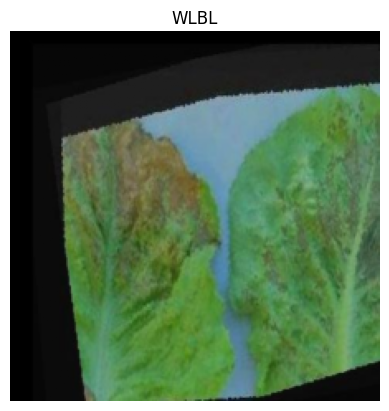

In [ ]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0))  # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(
    image.unsqueeze(0)
)  # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(
    0, 2, 1
)  # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(
    f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]"
)

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


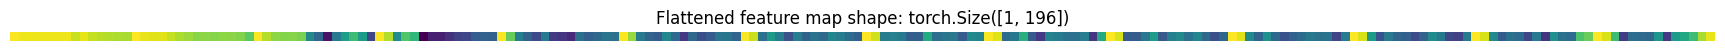

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[
    :, :, 0
]  # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [31]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.0288, -0.0354, -0.0354, -0.0354, -0.0354, -0.0354, -0.0351, -0.0521,
          -0.0385, -0.0538, -0.0591, -0.0618, -0.0645, -0.0660, -0.0276, -0.0374,
          -0.0414, -0.0408, -0.0535, -0.0645, -0.0711, -0.0801, -0.0790, -0.0821,
          -0.0787, -0.0789, -0.0846, -0.1027, -0.0297, -0.0608, -0.0782, -0.0830,
          -0.0819, -0.0881, -0.1859, -0.2270, -0.3105, -0.2019, -0.1593, -0.1218,
          -0.1633, -0.2631, -0.0293, -0.0620, -0.1823, -0.1088, -0.1287, -0.3266,
          -0.3006, -0.2997, -0.2838, -0.2680, -0.2631, -0.2368, -0.2323, -0.2354,
          -0.0293, -0.0974, -0.1978, -0.2315, -0.2568, -0.2047, -0.2745, -0.2795,
          -0.2893, -0.2167, -0.2351, -0.2232, -0.2111, -0.2135, -0.0293, -0.0734,
          -0.2047, -0.2290, -0.2409, -0.1887, -0.2241, -0.2771, -0.2257, -0.2552,
          -0.2405, -0.2089, -0.2108, -0.2288, -0.0293, -0.0518, -0.2146, -0.1642,
          -0.2000, -0.2523, -0.1978, -0.2314, -0.2139, -0.2232, -0.1896, -0.2007,
          -0.221

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

Time to put everything we've done for creating the patch embedding into a single PyTorch layer.

We can do so by subclassing `nn.Module` and creating a small PyTorch "model" to do all of the steps above.

Specifically we'll:
1. Create a class called `PatchEmbedding` which subclasses `nn.Module` (so it can be used a PyTorch layer).
2. Initialize the class with the parameters `in_channels=3`, `patch_size=16` (for ViT-Base) and `embedding_dim=768` (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using `nn.Conv2d()` (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above).
5. Define a `forward()` method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture (${N \times\left(P^{2} \cdot C\right)}$).

Let's do it!

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """

    # 2. Initialize the class with appropriate variables
    def __init__(
        self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768
    ):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
        )

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(
            start_dim=2,  # only flatten the feature map dimensions into a single vector
            end_dim=3,
        )

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert (
            image_resolution % patch_size == 0
        ), f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(
            0, 2, 1
        )  # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(
    image.unsqueeze(0)
)  # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


Beautiful!

The output shape matches the ideal input and output shapes we'd like to see from the patch embedding layer:

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Where:
* $(H, W)$ is the resolution of the original image.
* $C$ is the number of channels.
* $(P, P)$ is the resolution of each image patch (**patch size**).
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.
    
We've now replicated the patch embedding for equation 1 but not the class token/position embedding.

We'll get to these later on.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-replicating-the-patch-embedding-layer.png" width=900 alt="replicating the vision transformer architecture patch embedding layer"/>

*Our `PatchEmbedding` class (right) replicates the patch embedding of the ViT architecture from Figure 1 and Equation 1 from the ViT paper (left). However, the learnable class embedding and position embeddings haven't been created yet. These will come soon.*

Let's now get a summary of our `PatchEmbedding` layer.

In [ ]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(
    f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]"
)

tensor([[[-0.0297, -0.0146, -0.0292,  ...,  0.0140, -0.0027,  0.0071],
         [-0.0263, -0.0099, -0.0494,  ...,  0.0242,  0.0033,  0.0171],
         [-0.0263, -0.0099, -0.0494,  ...,  0.0242,  0.0033,  0.0171],
         ...,
         [-0.1059, -0.0673, -0.0168,  ...,  0.1625, -0.2068, -0.0271],
         [-0.0369, -0.0068, -0.0425,  ...,  0.0518, -0.0395,  0.0583],
         [-0.0548,  0.0010, -0.0324,  ...,  0.0371, -0.0257,  0.0123]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(
    torch.ones(
        batch_size, 1, embedding_dimension
    ),  # [batch_size, number_of_tokens, embedding_dimension]
    requires_grad=True,
)  # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(
    f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]"
)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat(
    (class_token, patch_embedded_image), dim=1
)  # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(
    f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]"
)

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0297, -0.0146, -0.0292,  ...,  0.0140, -0.0027,  0.0071],
         [-0.0263, -0.0099, -0.0494,  ...,  0.0242,  0.0033,  0.0171],
         ...,
         [-0.1059, -0.0673, -0.0168,  ...,  0.1625, -0.2068, -0.0271],
         [-0.0369, -0.0068, -0.0425,  ...,  0.0518, -0.0395,  0.0583],
         [-0.0548,  0.0010, -0.0324,  ...,  0.0371, -0.0257,  0.0123]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.7 Creating the position embedding

Well, we've got the class token embedding and the patch embedding, now how might we create the position embedding?

Or $\mathbf{E}_{\text {pos }}$ from equation 1 where $E$ stands for "embedding".

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-position-embeddings.png" width=900 alt="extracting the position embeddings from the vision transformer architecture and comparing them to other sections of the vision transformer paper"/>

*Left: Figure 1 from the ViT paper with the position embedding we're going to recreate highlighted. Right: Equation 1 and section 3.1 of the ViT paper that relate to the position embedding.*

Let's find out more by reading section 3.1 of the ViT paper (bold mine):

> Position embeddings are added to the patch embeddings to retain positional information. We use **standard learnable 1D position embeddings**, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

By "retain positional information" the authors mean they want the architecture to know what "order" the patches come in. As in, patch two comes after patch one and patch three comes after patch two and on and on.

This positional information can be important when considering what's in an image (without positional information and a flattened sequence could be seen as having no order and thus no patch relates to any other patch).

To start creating the position embeddings, let's view our current embeddings.

In [37]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0297, -0.0146, -0.0292,  ...,  0.0140, -0.0027,  0.0071],
          [-0.0263, -0.0099, -0.0494,  ...,  0.0242,  0.0033,  0.0171],
          ...,
          [-0.1059, -0.0673, -0.0168,  ...,  0.1625, -0.2068, -0.0271],
          [-0.0369, -0.0068, -0.0425,  ...,  0.0518, -0.0395,  0.0583],
          [-0.0548,  0.0010, -0.0324,  ...,  0.0371, -0.0257,  0.0123]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True
)  # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(
    f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]"
)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = (
    patch_embedded_image_with_class_embedding + position_embedding
)
print(patch_and_position_embedding)
print(
    f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]"
)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9703, 0.9854, 0.9708,  ..., 1.0140, 0.9973, 1.0071],
         [0.9737, 0.9901, 0.9506,  ..., 1.0242, 1.0033, 1.0171],
         ...,
         [0.8941, 0.9327, 0.9832,  ..., 1.1625, 0.7932, 0.9729],
         [0.9631, 0.9932, 0.9575,  ..., 1.0518, 0.9605, 1.0583],
         [0.9452, 1.0010, 0.9676,  ..., 1.0371, 0.9743, 1.0123]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.8 Putting it all together: from image to embedding

Alright, we've come a long way in terms of turning our input images into an embedding and replicating equation 1 from section 3.1 of the ViT paper:

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

Let's now put everything together in a single code cell and go from input image ($\mathbf{x}$) to output embedding ($\mathbf{z}_0$).

We can do so by:
1. Setting the patch size (we'll use `16` as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our `PatchEmbedding` layer.
4. Creating a `PatchEmbedding` layer (the one we made in section 4.5) with a `patch_size=16` and `embedding_dim=768` (from Table 1 for ViT-Base).
5. Passing the single image through the `PatchEmbedding` layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding like in section 4.6.
7. Prepending the class token embedding to the patch embeddings created in step 5.
8. Creating a position embedding like in section 4.7.
9. Adding the position embedding to the class token and patch embeddings created in step 7.

We'll also make sure to set the random seeds with `set_seeds()` and print out the shapes of different tensors along the way.

In [ ]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(
    in_channels=3, patch_size=patch_size, embedding_dim=768
)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension), requires_grad=True
)  # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True
)  # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: Multi-Head Attention (MSA)

We've got our input data patchified and embedded, now let's move onto the next part of the ViT architecture.

To start, we'll break down the Transformer Encoder section into two parts (start small and increase when necessary).

The first being equation 2 and the second being equation 3.

Recall equation 2 states:

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

We'll refer to equation 2 as the "MSA block".

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png" alt="mapping equation 2 from the ViT paper to the ViT architecture diagram in figure 1" width=900/>

***Left:** Figure 1 from the ViT paper with Multi-Head Attention and Norm layers as well as the residual connection (+) highlighted within the Transformer Encoder block. **Right:** Mapping the Multi-Head Self Attention (MSA) layer, Norm layer and residual connection to their respective parts of equation 2 in the ViT paper.*

Many layers you find in research papers are already implemented in modern deep learning frameworks such as PyTorch.

In saying this, to replicate these layers and residual connection with PyTorch code we can use:
* **Multi-Head Self Attention (MSA)** - [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **Norm (LN or LayerNorm)** - [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Residual connection** - add the input to output (we'll see this later on when we create the full Transformer Encoder block in section 7.1).

In [ ]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)."""

    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(
        self,
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        num_heads: int = 12,  # Heads from Table 1 for ViT-Base
        attn_dropout: float = 0,
    ):  # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True,
        )  # does our batch dimension come first?

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x,  # query embeddings
            key=x,  # key embeddings
            value=x,  # value embeddings
            need_weights=False,
        )  # do we need the weights or just the layer outputs?
        return attn_output

In [ ]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(
    embedding_dim=768, num_heads=12  # from Table 1
)  # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(
    patch_and_position_embedding
)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP)

We're on a roll here!

Let's keep it going and replicate equation 3:

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above).

And the addition on the end is the skip/residual connection.

We'll refer to equation 3 as the "MLP block" of the Transformer encoder (notice how we're continuing the trend of breaking down the architecture into smaller chunks).

<img src="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-equation-3-annotated.png" alt="mapping equation 3 from the ViT paper to the ViT architecture diagram in figure 1" width=900/>

***Left:** Figure 1 from the ViT paper with MLP and Norm layers as well as the residual connection (+) highlighted within the Transformer Encoder block. **Right:** Mapping the multilayer perceptron (MLP) layer, Norm layer (LN) and residual connection to their respective parts of equation 3 in the ViT paper.*

### 6.1 The MLP layer(s)

The term [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) is quite broad as it can refer to almost any combination of *multiple* layers (hence the "multi" in multilayer perceptron).

But it generally follows the pattern of:

`linear layer -> non-linear layer -> linear layer -> non-linear layer`

In the the case of the ViT paper, the MLP structure is defined in section 3.1:

> The MLP contains two layers with a GELU non-linearity.

Where "two layers" refers to linear layers ([`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) in PyTorch) and "GELU non-linearity" is the GELU  (Gaussian Error Linear Units) non-linear activation function ([`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) in PyTorch).

> **Note:** A linear layer (`torch.nn.Linear()`) can sometimes also be referred to as a "dense layer" or "feedforward layer". Some papers even use all three terms to describe the same thing (as in the ViT paper).

Another sneaky detail about the MLP block doesn't appear until Appendix B.1 (Training):

> Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied **after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.**

This means that every linear layer (or dense layer) in the MLP block has a dropout layer ([`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) in PyTorch).

The value of which can be found in Table 3 of the ViT paper (for ViT-Base, `dropout=0.1`).

Knowing this, the structure of our MLP block will be:

`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`

With hyperparameter values for the linear layers available from Table 1 (MLP size is the number of hidden units between the linear layers and hidden size $D$ is the output size of the MLP block).

In [ ]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(
        self,
        embedding_dim: int = 768,  # Hidden Size D from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        dropout: float = 0.1,
    ):  # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),  # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=mlp_size,  # needs to take same in_features as out_features of layer above
                out_features=embedding_dim,
            ),  # take back to embedding_dim
            nn.Dropout(
                p=dropout
            ),  # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(
    embedding_dim=768, mlp_size=3072, dropout=0.1  # from Table 1  # from Table 1
)  # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 7. Create the Transformer Encoder

Time to stack together our `MultiheadSelfAttentionBlock` (equation 2) and `MLPBlock` (equation 3) and create the Transformer Encoder of the ViT architecture.

In deep learning, an ["encoder" or "auto encoder"](https://paperswithcode.com/method/autoencoder) generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical representation).

In our case, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks, as per section 3.1 of the ViT Paper:

> The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019).

We've created MSA and MLP blocks but what about the residual connections?

[Residual connections](https://paperswithcode.com/method/residual-connection) (also called skip connections), were first introduced in the paper [*Deep Residual Learning for Image Recognition*](https://arxiv.org/abs/1512.03385v1) and are achieved by adding a layer(s) input to its subsequent output.

Where the subsequence output might be one or more layers later.

In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block.

And the same thing happens with the MLP block before it goes onto the next Transformer Encoder block.

Or in pseudocode:

`x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...`

What does this do?

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

> **Note:** The iconic computer vision architecture "ResNet" is named so because of the introduction of *res*idual connections. You can find many pretrained versions of ResNet architectures in [`torchvision.models`](https://pytorch.org/vision/stable/models.html).

In [ ]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(
        self,
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        num_heads: int = 12,  # Heads from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        mlp_dropout: float = 0.1,  # Amount of dropout for dense layers from Table 3 for ViT-Base
        attn_dropout: float = 0,
    ):  # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout
        )

        # 4. Create MLP block (equation 3)
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout
        )

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x = self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [46]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
# summary(model=transformer_encoder_block,
#         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,  # Hidden size D from Table 1 for ViT-Base
    nhead=12,  # Heads from Table 1 for ViT-Base
    dim_feedforward=3072,  # MLP size from Table 1 for ViT-Base
    dropout=0.1,  # Amount of dropout for dense layers from Table 3 for ViT-Base
    activation="gelu",  # GELU non-linear activation
    batch_first=True,  # Do our batches come first?
    norm_first=True,
)  # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(
    model=torch_transformer_encoder_layer,
    input_size=(1, 197, 768),  # (batch_size, num_patches, embedding_dimension)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## 8. Putting it all together to create ViT

Alright, alright, alright, we've come a long way!

But now it's time to do the exciting thing of putting together all of the pieces of the puzzle.

We're going to combine all of the blocks we've created to replicate the full ViT architecture.

From the patch and positional embedding to the Transformer Encoder(s) to the MLP Head.

But wait, we haven't created equation 4 yet...

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

Don't worry, we can put equation 4 into our overall ViT architecture class.

All we need is a `torch.nn.LayerNorm()` layer and a `torch.nn.Linear()` layer to convert the 0th index ($\mathbf{z}_{L}^{0}$) of the Transformer Encoder logit outputs to the target number of classes we have.

To create the full architecture, we'll also need to stack a number of our `TransformerEncoderBlock`s on top of each other, we can do this by passing a list of them to `torch.nn.Sequential()` (this will make a sequential range of `TransformerEncoderBlock`s).

We'll focus on the ViT-Base hyperparameters from Table 1 but our code should be adaptable to other ViT variants.

Creating ViT will be our biggest code block yet but we can do it!

Finally, to bring our own implementation of ViT to life, let's:

1. Create a class called `ViT` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Make sure the image size is divisible by the patch size (the image should be split into even patches).
4. Calculate the number of patches using the formula $N=H W / P^{2}$, where $H$ is the image height, $W$ is the image width and $P$ is the patch size.
5. Create a learnable class embedding token (equation 1) as done above in section 4.6.
6. Create a learnable position embedding vector (equation 1) as done above in section 4.7.
7. Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper.
8. Create the patch embedding layer using the `PatchEmbedding` class as above in section 4.5.
9. Create a series of Transformer Encoder blocks by passing a list of `TransformerEncoderBlock`s created in section 7.1 to `torch.nn.Sequential()` (equations 2 & 3).
10. Create the MLP head (also called classifier head or equation 4) by passing a `torch.nn.LayerNorm()` (LN) layer and a `torch.nn.Linear(out_features=num_classes)` layer (where `num_classes` is the target number of classes) linear layer to `torch.nn.Sequential()`.
11. Create a `forward()` method that accepts an input.
12. Get the batch size of the input (the first dimension of the shape).
13. Create the patching embedding using the layer created in step 8 (equation 1).
14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches found in step 11 using [`torch.Tensor.expand()`](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) (equation 1).
15. Concatenate the class token embedding created in step 13 to the first dimension of the patch embedding created in step 12 using [`torch.cat()`](https://pytorch.org/docs/stable/generated/torch.cat.html) (equation 1).
16. Add the position embedding created in step 6 to the patch and class token embedding created in step 14 (equation 1).
17. Pass the patch and position embedding through the dropout layer created in step 7.
18. Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers created in step 9 (equations 2 & 3).
19. Pass index 0 of the output of the stack of Transformer Encoder layers from step 17 through the classifier head created in step 10 (equation 4).
20. Done (VIT is ready !!)

In [50]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(
        self,
        img_size: int = 224,  # Training resolution from Table 3 in ViT paper
        in_channels: int = 3,  # Number of channels in input image
        patch_size: int = 16,  # Patch size
        num_transformer_layers: int = 12,  # Layers from Table 1 for ViT-Base
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        num_heads: int = 12,  # Heads from Table 1 for ViT-Base
        attn_dropout: float = 0,  # Dropout for attention projection
        mlp_dropout: float = 0.1,  # Dropout for dense/MLP layers
        embedding_dropout: float = 0.1,  # Dropout for patch and position embeddings
        num_classes: int = 1000,
    ):  # Default for ImageNet but can customize this
        super().__init__()  # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert (
            img_size % patch_size == 0
        ), f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, embedding_dim), requires_grad=True
        )

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True
        )

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim
        )

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(
            *[
                TransformerEncoderBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_size=mlp_size,
                    mlp_dropout=mlp_dropout,
                )
                for _ in range(num_transformer_layers)
            ]
        )

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes),
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(
            batch_size, -1, -1
        )  # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0])  # run on each sample in a batch at 0 index

        return x

In [51]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(
    data=torch.randn(1, 1, 768)
)  # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(
    batch_size, -1, -1
)  # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(
    f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}"
)

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [52]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(
    1, 3, 224, 224
)  # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.1860,  0.8479,  0.9881, -0.3590, -0.5064,  0.7241, -0.6677,  0.1969]],
       grad_fn=<AddmmBackward0>)

In [ ]:
from modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=3e-3,  # Base LR from Table 3 for ViT-* ImageNet-1k
    betas=(
        0.9,
        0.999,
    ),  # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
    weight_decay=0.3,
)  # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)